In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import ICRS, Galactic, FK4, FK5 

import os

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [26]:
%pylab inline
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse, also a double pulse
time_string5 = '2015-10-19T00:55:15.557' #S/N = 8.33, main pulse
time_string6 = '2015-10-19T00:55:49.673' #S/N = 8.55, main pulse
time_string7 = '2015-10-19T01:29:52.509' #S/N = 8.44, main pulse
time_string8 = '2015-10-19T01:55:06.340' #S/N = 8.66, main pulse
time_string9 = '2015-10-19T02:13:46.551' #S/N = 9.56, main pulse
time_string10 = '2015-10-19T02:36:11.418'#S/N = 8.41, main pulse

time_string13 = '2015-10-19T00:37:14.418' # close main pulse pair
time_string14 = '2015-10-19T00:37:15.126'

time_string15 = '2015-10-19T01:57:05.107' # the closest main pulse pair 
time_string16 = '2015-10-19T01:57:05.410'

time_string17 = '2015-10-19T00:56:55.579' # close pair by 1.078s
time_string18 = '2015-10-19T00:56:54.501' 

time_string19 = '2015-10-19T02:17:06.664' #close pair by 1.281s
time_string20 = '2015-10-19T02:17:07.945' 

time_string21 = '2015-10-19T01:28:04.429' #close pair by 1.65
time_string22 = '2015-10-19T01:28:06.081' 

time_string23 = '2015-10-19T01:44:15.701' # close pair by 1.98
time_string24 = '2015-10-19T01:44:17.690' 

time_string25 = '2015-10-19T01:29:52.509' # close main pulse pair by 2.09
time_string26 = '2015-10-19T01:29:54.600' 

time_string27 = '2015-10-18T23:47:20.315' # close interpulse and main pulse pair (interpulse) by 0.49s
time_string28 = '2015-10-18T23:47:20.807' #main pulse for the above pair 

Populating the interactive namespace from numpy and matplotlib


In [3]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:20]) 
    noise_mean = np.mean(outputsumfreq[:20])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
    return sigs_noise

def load_gp(time_string,telescope,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
    gp1 = np.load('/mnt/raid-cita/ramain/EVN-GPs/SN5/PulseBaseband-SN5/GP{}/{}'.format(telescope,time_string))
    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T

    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    sn_sorted = np.argsort(sigs_noise)

    peak_time = np.argmax(sigs_noise)
    return output, peak_time, sigs_noise

In [4]:
def get_output_from_dchan(gp1s,nchan):
    gp1t = np.fft.irfft(gp1s,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T
    return output

In [50]:
filelist = []
for file_name in os.listdir('/mnt/raid-cita/xzxu/GPs/GPef'):
    output,increased_ratio = add_pulses(file_name)

In [49]:
teles = ['ef','hh','jb','mc','o8','sv','tr','wb','zc']
# teles = ['ef','jb','wb']
nchan = 32
def add_pulses(time_string):
    '''New add pulses using my saved files from convolving and finding shift'''
    fs1 = np.load('/mnt/raid-cita/xzxu/GPs/GP{}/{}'.format(teles[0],time_string))
    output1 = get_output_from_dchan(fs1,nchan)
    outputsum = output1.copy()
    for tele in teles[1:]:   
        if os.path.exists('/mnt/raid-cita/xzxu/GPs/GP{}/{}'.format(tele,time_string)):
            fs2 = np.load('/mnt/raid-cita/xzxu/GPs/GP{}/{}'.format(tele,time_string))
            output2 = get_output_from_dchan(fs2,nchan)
            outputsum+=output2
    np.save('/mnt/raid-cita/xzxu/GPs/GPp1-32/{}'.format(time_string),outputsum)
    snef = max(get_SN(output1.sum(0)))
    sno = max(get_SN(outputsum.sum(0)))
    return outputsum,sno/snef

(136, 512)
2.59081951436
ef exists
hh exists
jb exists
mc exists
o8 exists
sr exists
sv exists
tr exists


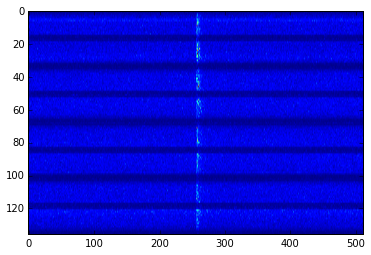

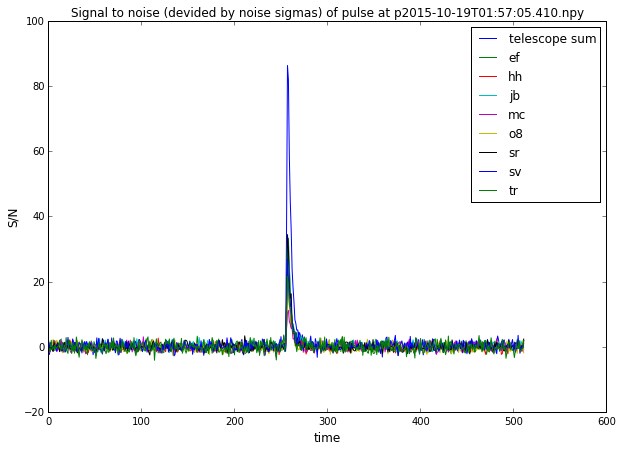

In [47]:
time_string = 'p'+time_string16+'.npy'
o ,snr = add_pulses(time_string)
imshow(o,aspect = 'auto')
print o.shape
print snr

figure(figsize = (10,7))
plot(get_SN(o.sum(0)),label = 'telescope sum')
for i in range(8):
    if os.path.exists('/mnt/raid-cita/xzxu/GPs/GP{}/{}'.format(teles[i],time_string)):
        print teles[i],'exists'
        fs1 = np.load('/mnt/raid-cita/xzxu/GPs/GP{}/{}'.format(teles[i],time_string))
        plot(get_SN(get_output_from_dchan(fs1,nchan).sum(0)),label = teles[i])
    else:
        print teles[i], 'does not exists'
legend()
title('Signal to noise (devided by noise sigmas) of pulse at {}'.format(time_string))
xlabel('time',fontsize = 12)
ylabel('S/N',fontsize = 12)

In [ ]:
def add_pulses1(time_string):
    '''Old add pulses
    Takes in a list output powers from load_gp (outputs)
    Returns an output of summed pulses as numpy arrays to be saved in my directory, 
    a signal to noise ratio as a float, and a signal to nosie array of the pulse in time'''
    output1,peak_time1,sn1 = load_gp(time_string,teles[0],nchan)
    outputsum = output1 
    for tele in teles[1:]:
        if os.path.exists('/mnt/raid-cita/ramain/EVN-GPs/SN5/PulseBaseband-SN5/GP{}/{}'.format(tele,time_string)):
            output2,peak_time2,sn2 = load_gp(time_string,tele,nchan)
            output2 = roll(output2,peak_time1-peak_time2,axis = 1)
            outputsum = outputsum+output2
        else:
            print tele+' doesn\'t have data'

#     outputsumfreq = get_output_from_dchan(outputsum,nchan).sum(0)
    outputsumfreq = outputsum.sum(0)
    sig_noise = get_SN(outputsumfreq)
    peak_time = argmax(outputsumfreq)
    snef = max(sn1)
    snsum = max(sig_noise)
    return outputsum, snsum/snef,sig_noise

time_string = time_string1
gp1, snr,sn = add_pulses('p'+time_string+'.npy')

print snr
plot(sn)

output1,peak_time1,sn1 = load_gp('p'+time_string+'.npy',teles[0],nchan)
output2,peak_time2,sn2 = load_gp('p'+time_string+'.npy',teles[1],nchan)
output3,peak_time3,sn3 = load_gp('p'+time_string+'.npy',teles[2],nchan)
plot(sn1)
plot(sn2)
plot(sn3)

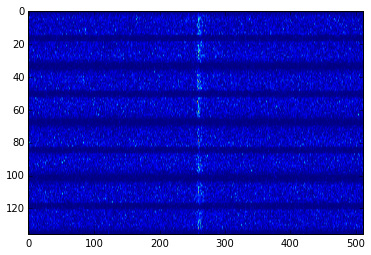

In [119]:
plt.imshow(output3, aspect='auto')

130 128
(264, 256)


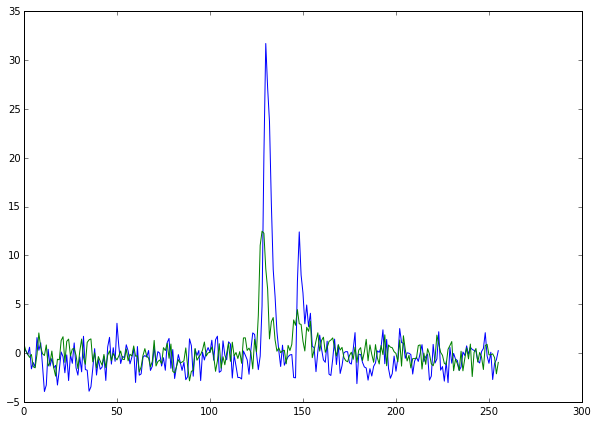

In [5]:
nchan = 32
tele1 = 'ef'
tele2 = 'o8'
gp1s,peak_time1,sn1 = load_gp('p{}.npy'.format(time_string4),tele1,nchan)
gp2s,peak_time2,sn2 = load_gp('p{}.npy'.format(time_string4),tele2,nchan)

plt.figure(figsize = (10,7))
plt.plot(sn1)
plt.plot(sn2)

print peak_time1,peak_time2
print gp1s.shape

In [6]:
print max(sn1)
print max(sn2)

31.693175317
12.4714248669


In [41]:
output1 = get_output_from_dchan(gp1s,nchan)
output2 = get_output_from_dchan(gp2s,nchan)

gp2sn = roll(gp2s,peak_time1-peak_time2,axis = 0)
output2n = get_output_from_dchan(gp2sn,nchan)
outputsumfreq = output2n.sum(0)
sig_noise = get_SN(outputsumfreq)
peak_time2n = argmax(outputsumfreq)
print peak_time2n

# plt.figure(figsize = (15,10))
# plt.plot(sn1)
# plt.plot(sig_noise)

print output2n.shape


260
(136, 512)


17.1258730018


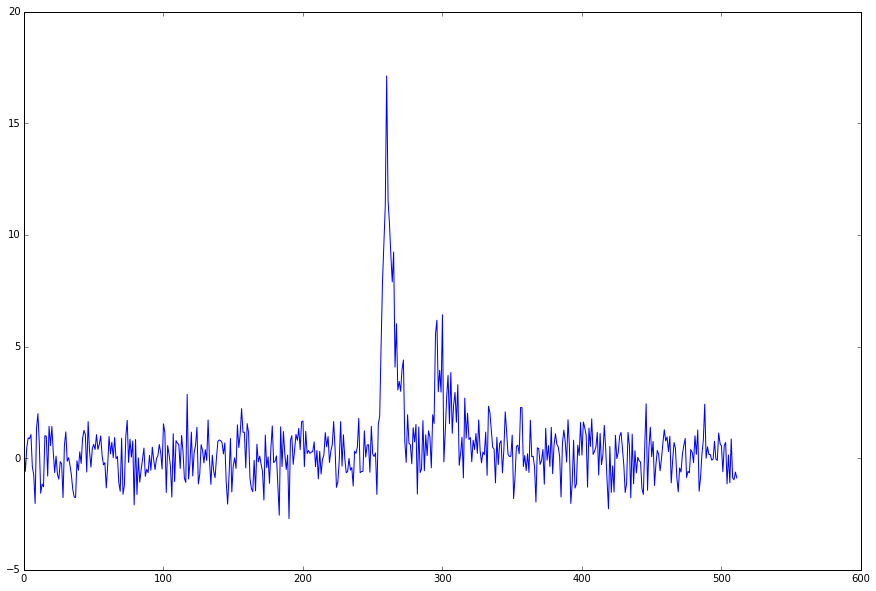

In [43]:
outputsum = get_output_from_dchan(gp2sn+gp1s,nchan)
outputsumfreqs = outputsum.sum(0)
sig_noises = get_SN(outputsumfreqs)
plt.figure(figsize = (15,10))
plt.plot(sig_noises)
print max(sig_noises)